# Non Linear Regression with Arrhenius model

In this example, we show how to use Non-Linear Regression which is
scikit-learn-style way to easily fit non-linear models to data.
It can handle any kind of models as such, but the most linear kinds of models
are natively handled in sklearn.

Moreover, it can be easily used with the parametric model inference API
to do model inference and learn more about the fitted model.

In [1]:
# Import necessary libraries.
from ml_uncertainty.non_linear_regression import NonLinearRegression
from ml_uncertainty.model_inference import ParametricModelInference
import autograd.numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
#%%
# Let's say have some experimental data for a rate constant study.
# Let's say we wish to fit an Arrhenius model to it.
# Let's say we use the data provided in the link below to study
# the rate of reaction for conversion of cyclopropane to propene.
# Source: See in source for arrhenius model.


def arrhenius_model(T, coefs_):
    r"""Arrhenius model function for rate of reaction prediction.

    $$ k = Ae^{-Ea/RT}$$

    Source: https://chem.libretexts.org/Bookshelves/
    Physical_and_Theoretical_Chemistry_Textbook_Maps/
    Supplemental_Modules_(Physical_and_Theoretical_Chemistry)/
    Kinetics/06%3A_Modeling_Reaction_Kinetics/
    6.02%3A_Temperature_Dependence_of_Reaction_Rates/
    6.2.03%3A_The_Arrhenius_Law/6.2.3.01%3A_Arrhenius_Equation

    Parameters:
    -----------
    T: np.ndarray of dimension 1
        Temperatures in $\degree C$
    coefs_: np.ndarray of shape (2,)
        Denotes [A, Ea].
        A (units: same as those of rate constant k),
        Ea (units: J/mol).

    Returns:
    --------
    np.ndarray of dimension 1.
        Corresponding to k values for each T value.
    """

    X = T[:, 0] + 273  # transforming to K
    R = 8.314  # J/mol/K
    A, Ea = coefs_
    k = A * np.exp(-Ea / (R * X))
    k = k.reshape((-1,))
    return k


   experimental    nlr_fitted
A  1.394065e+15  3.200334e+09
E  2.718670e+05  1.734450e+05


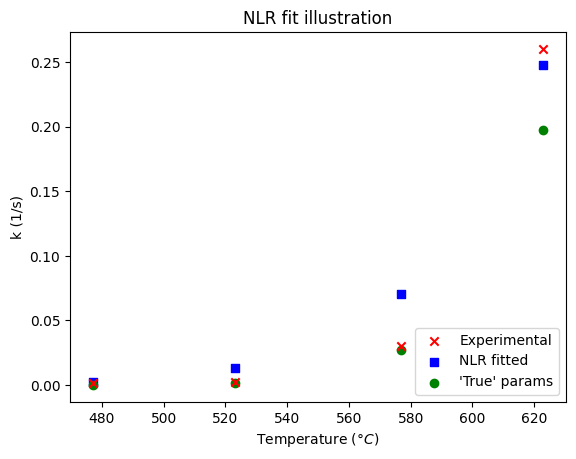

In [3]:
#%%
# The data provided is as follows: ($\degree C$)
T_expt = np.array([477, 523, 577, 623])

# For these values, the experimental k values are as follows: (1/s)
k_expt = np.array([0.0018, 0.0027, 0.030, 0.26])

# They have reported best fit parameters which they obtained.
# Calculated linearizing the Arrhenius model and fitting it to data.
# This might not be the best approach, but for this example, we consider it the
# ground truth.
# Ea: provided, A: calculated accordingly.
# A: 1/s, Ea: J/mol
true_params = np.array([1.39406453358858e15, 271.867e3])

#%%
# Let's say we wish to estimate the Arrhenius model parameters for it.
# Normally, we might have to use scipy.optimize or some other optimizer,
# but with NonLinearRegression, this can be done more easily and if fewer steps.

# Instantiate the class
nlr = NonLinearRegression(model=arrhenius_model, p0_length=2)

# Ensure that the shape of T_expt is (m,1) rather than (m,).
T_expt_mat = T_expt.reshape((-1, 1))

# Fit the model and get the parameters. Initial guess is provided by
# Taking 0.5 x these values. Of course, we can also use some other initial guess.
nlr.fit(T_expt_mat, k_expt, p0=true_params * 0.5)

# Compute the predicted values from the NLR fit.
k_pred = nlr.predict(T_expt_mat)

# Compute the predicted values from "true params".
# NOTE: The nlr.predict method takes 'params' as an optional argument.
# This means that if you wish to obtain predictions for a different set of params,
# this can be done. This exactly the same as getting these from the model directly.
# And it is a different functionality from scikit-learn.
k_true_pred = nlr.predict(T_expt_mat, params=true_params)

# Compare known parameters with fitted parameters.
df_param = pd.DataFrame(index=["A", "E"])
df_param["experimental"] = true_params
df_param["nlr_fitted"] = nlr.coef_

print(df_param)

# Plot the results.
plt.figure()
plt.xlabel(r"Temperature ($\degree C$)")
plt.ylabel(r"k (1/s)")
plt.title("NLR fit illustration")

# Showing experimental points and predicted points.
plt.scatter(T_expt, k_expt, marker="x", color="red", zorder=1, label="Experimental")
plt.scatter(T_expt, k_pred, marker="s", color="blue", zorder=0.5, label="NLR fitted")
plt.scatter(
    T_expt, k_true_pred, marker="o", color="green", zorder=0.7, label="'True' params"
)

plt.legend(loc="lower right")


   experimental    nlr_fitted       nlr_std  lower_bound_90%_conf  \
A  1.394065e+15  3.200334e+09  7.339434e+09         -1.823071e+10   
E  2.718670e+05  1.734450e+05  1.698239e+04          1.238567e+05   

   upper_bound_90%_conf  
A          2.463137e+10  
E          2.230333e+05  


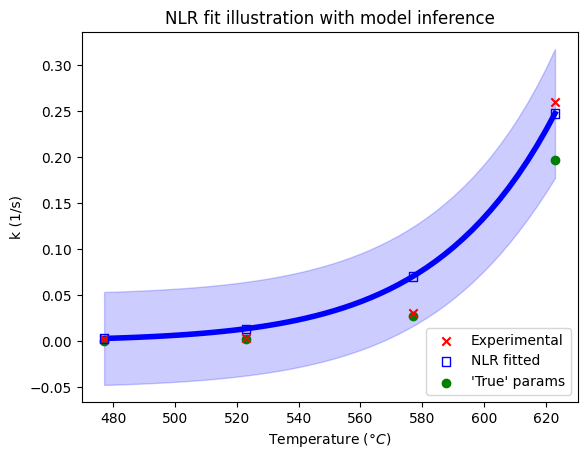

In [4]:
#%%
# Great! So, we have fitted some parameters. Clearly, they do not
# look like those reported. Let's investigate more. Are they significant?
# We use the parametric model inference utility to answer this question.

# Model inference
inf = ParametricModelInference()

inf.set_up_model_inference(X_train=T_expt_mat, y_train=k_expt, estimator=nlr)

# Get prediction intervals on the features.
df_feature_imp = inf.get_parameter_errors()

# Compute confidence intervals for new T values.
T_new = np.linspace(T_expt.min(), T_expt.max(), 50).reshape((-1, 1))

k_new = nlr.predict(T_new)

df_int = inf.get_intervals(T_new)

# Look at the parameter errors for these.
df_param["nlr_fitted"] = df_feature_imp["mean"].values
df_param["nlr_std"] = df_feature_imp["std"].values
df_param["lower_bound_90%_conf"] = df_feature_imp["lower_bound"].values
df_param["upper_bound_90%_conf"] = df_feature_imp["upper_bound"].values

print(df_param)

# Plot the prediction intervals.
plt.figure()
plt.xlabel(r"Temperature ($\degree C$)")
plt.ylabel(r"k (1/s)")
plt.title("NLR fit illustration with model inference")

# Showing experimental points and predicted points.
plt.scatter(T_expt, k_expt, marker="x", color="red", zorder=1, label="Experimental")
plt.scatter(
    T_expt,
    k_pred,
    marker="s",
    edgecolor="blue",
    facecolor="none",
    zorder=1,
    label="NLR fitted",
)
plt.scatter(
    T_expt, k_true_pred, marker="o", color="green", zorder=0.7, label="'True' params"
)

plt.plot(T_new[:, 0], df_int["mean"], lw=4, color="blue", zorder=0.5)

plt.fill_between(
    T_new[:, 0],
    df_int["lower_bound"],
    df_int["upper_bound"],
    color="blue",
    alpha=0.2,
    zorder=0,
)

plt.legend(loc="lower right")


## Closing comments:
1. We can see here that the prediction intervals are really large.
This is expected since the error degree of freedom is 1.
Had we had more points, we would have had more clarity.
2. The discrepancy between the parameters we obtained and those
obtained by the authors of the source was due to the fact they linearized
the model while fitting it. This can sometimes be a handy trick,
but special care should be taken about the distributions from which the
data points are drawn during the transformation.
Since they log-transformed the data, they tend to fit to the lower k region
while we tend to fit to the higher k region. We can see that in the fit.
